In [1]:
from syntax_sugar import END, pipe
from syntax_sugar import process_syntax as p
from syntax_sugar import thread_syntax as t
NTHR = 16
import os
from os.path import join

In [2]:
from scipy.integrate import quad

import TMQGP as tm
from numpy import *

import QuarkTM
from QuarkTM import Channel, ChannelGroup, ChannelL, Particle

import matplotlib
matplotlib.style.use('publication23')

mQ = 0.6


qrange = linspace(0, 5, 51)
erange = linspace(-5, 5, 201)
eps = 10e-2
# pt = QuarkTM.Particle(mQ, qrange, erange, eps=5e-2)

G = 4
L = 0.5
screen = 0
G1 = 5/3

# ch = QuarkTM.Channel(pt, pt, T, G=8, screen=0, ds=4, da=1, Fa=1)

import tqdm

from scipy.optimize import minimize

params = {'G' : G, 'L' : L, 'screen' : screen}
params1 = {'G' : G1, 'L' : L, 'screen' : screen}
pss = [params, params1]
mu = 0
lmax = 0

In [3]:
T = 0.2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def f(x, T):
    return 1/(exp(x/T) + 1)

Start of iterations

In [131]:
quark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu)
aquark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu)

In [132]:
lmax = 0

In [133]:
imss = array([array([-eps for q in qrange])]*2).transpose()
ress = array([array([0. for q in qrange])]*2).transpose()

In [134]:
eArr = array([erange for q in qrange]).transpose()

In [135]:
omKs = array([sqrt(mQ**2 + qrange**2)]*2).transpose()

In [168]:
mu = 1*T

In [169]:
subtr = 1

In [170]:
DELTA = 1

In [171]:
while DELTA > 1e-3:
    
    # if len(ims) == 0 or len(res) == 0:
    channels_QQ = QuarkTM.ChannelGroup(mu0=False)
    channels_QA = QuarkTM.ChannelGroup(mu0=False)
    channels_AA = QuarkTM.ChannelGroup(mu0=False)
    channels_AQ = QuarkTM.ChannelGroup(mu0=False)
    
    # ImS_K_Arr = array([ims for e in er|ange])
    # ReS_K_Arr = array([res for e in erange])
    
    ImS_K_Arrs = [array([ims for e in erange]) for ims in imss.transpose()]
    ReS_K_Arrs = [array([res for e in erange]) for res in ress.transpose()]
    
    
    omArrs = [array([omk for e in erange]) for omk in omKs.transpose()]
    
    G2_QQ = (1 - 2*f(omArrs[0], T)) / (eArr - 2*omArrs[0] - 1j*2*ImS_K_Arrs[0] + 2*mu)
    G2_QA = (1 - f(omArrs[0], T) - f(omArrs[1], T)) / (eArr - omArrs[0] - omArrs[1] - 1j*(ImS_K_Arrs[0] + ImS_K_Arrs[1]))
    G2_AA = (1 - 2*f(omArrs[1], T)) / (eArr - 2*omArrs[1] - 1j*2*ImS_K_Arrs[1] - 2*mu)
    
    
    channels_QQ.addChannel(
        QuarkTM.ChannelL('qq3', lmax, quark_run, quark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QQ)
    )
    
    channels_QA.addChannel(
        QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QA)
    )
    
    channels_AA.addChannel(
        QuarkTM.ChannelL('aa3', lmax, aquark_run, aquark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_AA)
    )
    
    channels_AQ.addChannel(
        QuarkTM.ChannelL('aq1', lmax, aquark_run, quark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QA)
    )

    chs_Q = [channels_QQ, channels_QA]
    chs_A = [channels_AQ, channels_AA]
    
    Gs_Q = [G2_QQ, G2_QA]
    Gs_A = [G2_QA, G2_AA]

    omKs_old = omKs.copy()
    
    omKs = []
    ress = []
    imss = []
    
    for k in tqdm.notebook.tqdm(qrange):
        xs = []
        res = []
        ims = []
        for i, chs, Gs, lbl in zip(range(2), [chs_Q, chs_A], [Gs_Q, Gs_A], ['Q', 'A']):
            delta = 1
            # print(lbl)
            x = sqrt(mQ**2 + k**2) # initial guess
    
            while delta > 1e-3:
                re = 0
                im = 0
                for j, ch in enumerate(chs):
                    TM = ch.get_T()
                    TM[erange < 0] = real(TM[erange < 0])
                    if subtr:
                        TM -= (TM[0, :] + TM[1, :])/2
                    iReTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(real(TM)))
                    iImTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(TM)))
                    iEps_i = tm.Interpolator(qrange, ascontiguousarray(omArrs[i][0, :]), 'cubic')
                    iEps_j = tm.Interpolator(qrange, ascontiguousarray(omArrs[j][0, :]), 'cubic')
                    _re = tm.SigmaQP(float(x), k, T, iReTM, quark_run.R, iEps_i, iEps_j, 0, 0)
                    _im = tm.SigmaQP(float(x), k, T, iImTM, quark_run.R, iEps_i, iEps_j, 0, 0)
                    re += _re
                    im += _im
                x0 = x
                x = sqrt(mQ**2 + k**2) + re
                delta = abs(x - x0)
                # print('k = ', k, 'delta = ', delta)
            xs += [x]
            ims += [im]
            res += [re]
        omKs += [xs]
        ress += [res]
        imss += [ims]

    omKs = array(omKs)
    omKs_old = array(omKs_old)
    imss = array(imss)
    ress = array(ress)

    DELTA = np.max(abs(omKs_old - omKs))
    print(DELTA)

  0%|          | 0/51 [00:00<?, ?it/s]

0.0051687442567103226


  0%|          | 0/51 [00:00<?, ?it/s]

0.004416140548865077


  0%|          | 0/51 [00:00<?, ?it/s]

0.00015425681851044537


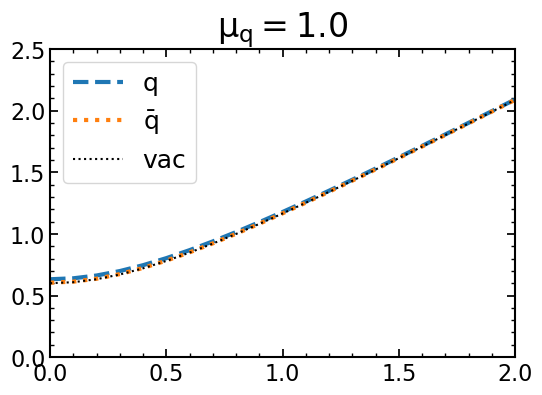

In [172]:
lQ, = plt.plot(qrange, omKs[:, 0], ls='--', label='q')
lA, = plt.plot(qrange, omKs[:, 1], ls=':', label=r'$\bar q$')
plt.plot(qrange, sqrt(mQ**2 + qrange**2), ls=':', lw=1.5, c='black', label='vac')

plt.legend()

plt.xlim(0, 2)
plt.ylim(0, 2.5)
plt.title(fr'$\mu_q = {mu/T}$')

suff = ''
if subtr:
    suff = '_subtr'

plt.savefig('omk_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')

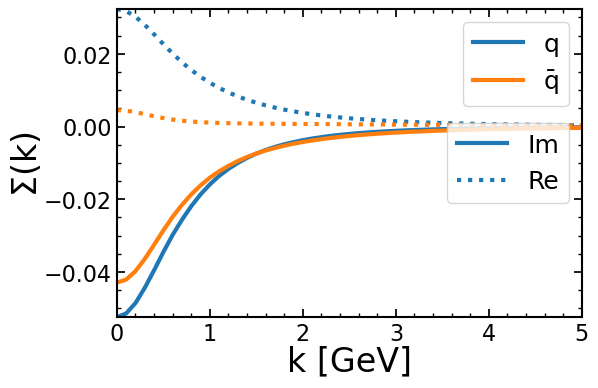

In [173]:
lQ, = plt.plot(qrange, imss[:, 0], ls='-')
lQre, = plt.plot(qrange, ress[:, 0], ls=':', c=lQ.get_c())

lA, = plt.plot(qrange, imss[:, 1], ls='-')
plt.plot(qrange, ress[:, 1], ls=':', c=lA.get_c())

leg = plt.legend([lQ, lQre], ['Im', 'Re'], loc='center right')

leg2 = plt.legend([lQ, lA], ['q', r'$\bar q$'])

plt.gca().add_artist(leg)

# plt.plot(qrange, sqrt(mQ**2 + qrange**2))

# plt.xlim(0, 2)
# plt.ylim(0, 2.5)
plt.ylabel(r'$\Sigma(k)$')
plt.xlabel('k [GeV]')

plt.savefig('Sk_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')


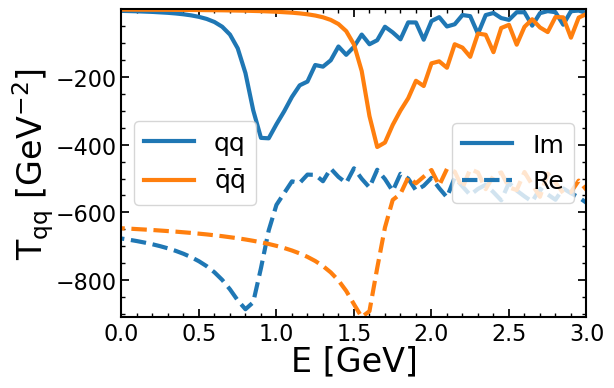

In [174]:
lq, = plt.plot(erange, imag(channels_QQ.get_T())[:, 0], label='qq')
la, = plt.plot(erange, imag(channels_AA.get_T())[:, 0], label='\bar q q')

lqre, = plt.plot(erange, real(channels_QQ.get_T())[:, 0], c=lq.get_c(), ls='--')
plt.plot(erange, real(channels_AA.get_T())[:, 0], c=la.get_c(), ls='--')

plt.ylabel(r'$T_{qq}$ [GeV$^{-2}$]')
plt.xlabel(r'E [GeV]')

leg = plt.legend([lq, lqre], ['Im', 'Re'], loc='center right')

leg2 = plt.legend([lq, la], ['qq', r'$\bar q \bar q$'], loc='center left')
plt.gca().add_artist(leg)

plt.xlim(0, 3)

plt.savefig('T_qq_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')


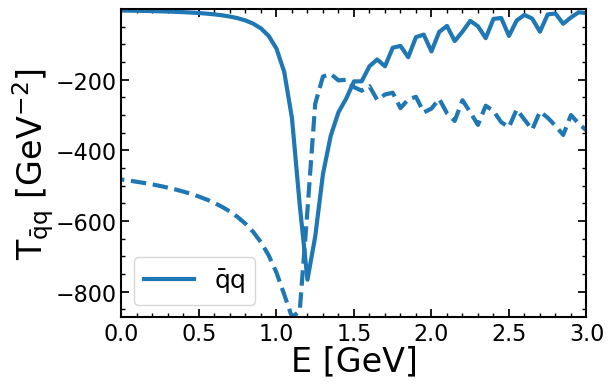

In [175]:
plt.plot(erange, imag(channels_QA.get_T())[:, 0], label=r'$\bar qq$')
# la, = plt.plot(erange, imag(channels_AA.get_T())[:, 0], label='\bar q q')

plt.plot(erange, real(channels_QA.get_T())[:, 0], c=lq.get_c(), ls='--')
# plt.plot(erange, real(channels_AA.get_T())[:, 0], c=la.get_c(), ls='--')

plt.ylabel(r'$T_{\bar qq}$ [GeV$^{-2}$]')
plt.xlabel(r'E [GeV]')

# leg = plt.legend([lq, lqre], ['Im', 'Re'], loc='center right')

# leg2 = plt.legend([lq, la], ['qq', r'$\bar q \bar q$'], loc='center left')
plt.legend()
# plt.gca().add_artist(leg)

plt.xlim(0, 3)
plt.savefig('T_qa_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')


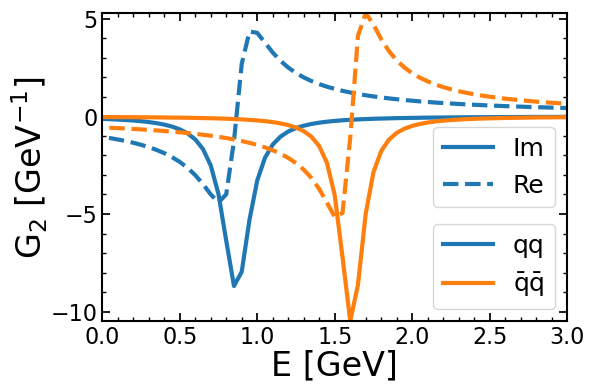

In [176]:
lq, = plt.plot(erange, imag(G2_QQ)[:, 0], label='qq')
la, = plt.plot(erange, imag(G2_AA)[:, 0], label='\bar q q')

lqre, = plt.plot(erange, real(G2_QQ)[:, 0], c=lq.get_c(), ls='--')
plt.plot(erange, real(G2_AA)[:, 0], c=la.get_c(), ls='--')

plt.ylabel(r'$G_{2}$ [GeV$^{-1}$]')
plt.xlabel(r'E [GeV]')

leg = plt.legend([lq, lqre], ['Im', 'Re'], loc='center right')

leg2 = plt.legend([lq, la], ['qq', r'$\bar q \bar q$'], loc='lower right')
plt.gca().add_artist(leg)

plt.xlim(0, 3)

plt.savefig('G2_qq_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')
